# Unsupervised Machine Learning for Perovskite Thin-Film in-situ Data using Clustering Algorithms for Solar Cell Performance Prediction

In [1]:
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
import h5py
from sklearn.cluster import KMeans
from matplotlib import cm
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, MaxAbsScaler, QuantileTransformer, RobustScaler, PowerTransformer
from matplotlib.lines import Line2D
import matplotlib.colors as colors

In [2]:
# define plotting parameters
pceLims = (5,17.5)
vocLims = (0.9,1.15)
jscLims = (16,22)
ffLims = (40,75)
fontSizeSetLarge = 18
fontSizeSetMedium = 14
fontSizeSetTitle = 26

In [3]:
# define plotting function
def boxPlot2DataSeries(ax,data1,data2,label1,label2,labelNames,xlabel,ylabel,saveName,title, plotDots,save):
    ks = np.linspace(0.3,0.9,len(data1))
    color_list = []
    cmap = plt.cm.get_cmap('viridis')
    for zz in range(len(ks)):
        color_list.append(cmap(ks[zz]))
    medianprops = dict(linestyle = '-', linewidth = 2.5, color = 'k')
    meanpointprops = dict(marker = 'D', markeredgecolor = 'black',markerfacecolor = 'white')
    bpl = ax.boxplot(data1, positions = np.array(range(1,1+len(data1)))*2.0-0.4, sym = '', widths = 0.6, medianprops = medianprops, meanprops = meanpointprops, meanline = False, showmeans = True, patch_artist = True)
    bpr = ax.boxplot(data2, positions = np.array(range(1,1+len(data2)))*2.0+0.4, sym = '', widths = 0.6, medianprops = medianprops, meanprops = meanpointprops,meanline = False, showmeans = True, patch_artist = True)
    cnt = 0
    for box in bpl['boxes']:
        box.set_alpha(0.35)
        box.set(facecolor = color_list[cnt]) 
        cnt += 1
    cnt = 0
    for box in bpr['boxes']:
        box.set_alpha(0.99)
        box.set(facecolor = color_list[cnt]) 
        cnt += 1
    ax.fill_between([],[], color = "k", alpha = 0.3, label = label1)
    ax.fill_between([],[], color = "k", alpha = 0.65, label = label2)
    ax.set_xticks(range(2,2+len(labelNames)*2,2), minor = False)
    ax.set_xticklabels(labelNames, fontdict = None, minor = False)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.legend(loc = 'lower right')
    ax.set_title(title)
    if plotDots == True:
        for i in range(len(data1)):
            y = data1[i]
            x = np.random.normal(i*2+2-0.4, 0.09, size = len(y))
            ax.plot(x, y, 'k.', alpha = 0.5) 
        for i in range(len(data2)):
            y = data2[i]
            x = np.random.normal(i*2+2+0.4, 0.09, size = len(y))
            ax.plot(x, y, 'k.', alpha = 0.2) 

In [4]:
# read in data 
pathData_train = '/pfs/data5/home/kit/lti/rk3078/JupyterNotebooks/data/singleDF_Train.h5'
db_train = pd.read_hdf(pathData_train, 'df')
pathData_test = '/pfs/data5/home/kit/lti/rk3078/JupyterNotebooks/data/singleDF_Test.h5'
db_test = pd.read_hdf(pathData_test, 'df')

In [5]:
# get data acquired through the LP725 filter
data = pd.DataFrame(data = np.vstack(db_train["LP725"].to_numpy()))

# generate a kmeans model with k = 4
k = 4
X_train = data.values.copy()
km = KMeans(n_clusters = k, random_state = 0)
cluster_found = km.fit_predict(X_train)
trainClustering = data.set_index(pd.Series(cluster_found, name = 'cluster'), append = True )
cluster_values = sorted(trainClustering.index.get_level_values('cluster').unique())

# generate a nested list with the PV parameters (pce,voc,jsc,ff) for the 4 generated clusters
listPCE,listVOC,listJSC,listFF = [],[],[],[]
for cluster in cluster_values:
    clusterDF = trainClustering.xs(cluster, level = 1)
    listPCE.append(db_train.iloc[clusterDF.index]["pce_backward"])
    listVOC.append(db_train.iloc[clusterDF.index]["voc_backward"])
    listJSC.append(db_train.iloc[clusterDF.index]["jsc_backward"])
    listFF.append(db_train.iloc[clusterDF.index]["ff_backward"])
pvParamsClusters_unsorted = [listPCE,listVOC,listJSC,listFF]

# sort the nested list. the order of the clusters is changed so that the median pce of the cluster increases with cluster number
medianList = []
for x in range(len(listPCE)):
    medianList.append(np.median(listPCE[x]))
sortBy = sorted(range(len(medianList)), key = lambda k: medianList[k])
newClusters = []
for a in range(len(sortBy)):
    newClusters.append(sortBy.index(a))
cluster_found_sorted = pd.Series(np.array(newClusters)[np.array(trainClustering.index.get_level_values('cluster'))], name = 'cluster')
trainClustering = data.set_index(cluster_found_sorted, append = True )
clusters = sorted(trainClustering.index.get_level_values('cluster').unique())
listPCE_sorted = np.array(listPCE,dtype = object)[sortBy]
listVOC_sorted = np.array(listVOC,dtype = object)[sortBy]
listJSC_sorted = np.array(listJSC,dtype = object)[sortBy]
listFF_sorted = np.array(listFF,dtype = object)[sortBy]
pvParamsClusters = [listPCE_sorted,listVOC_sorted,listJSC_sorted,listFF_sorted]

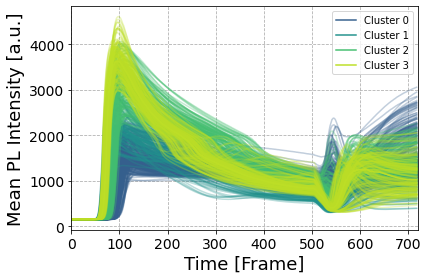

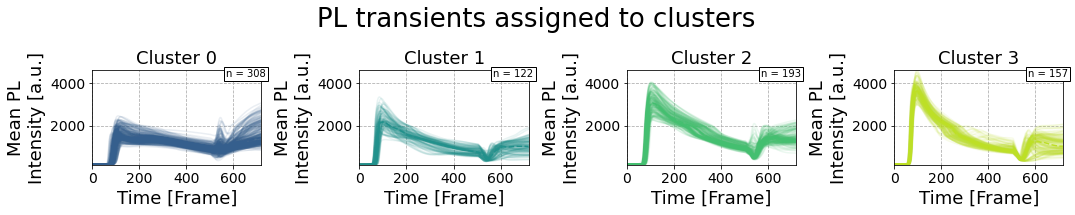

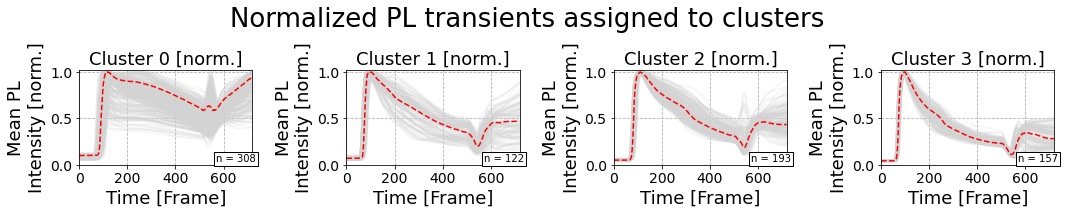

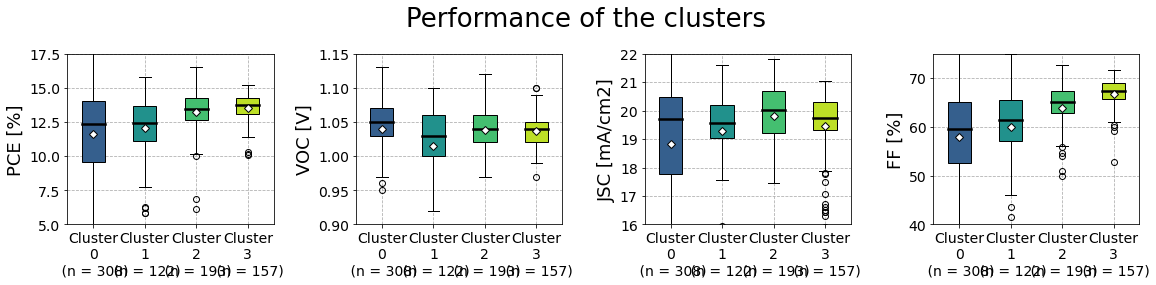

In [6]:
# generate 4 colors from the colormap viridis
ks = np.linspace(0.3,0.9,k)
color_list = []
cmap = plt.cm.get_cmap('viridis')
for zz in range(len(ks)):
    color_list.append(cmap(ks[zz]))
    
# plot all PL transient color-coded depending on the cluster they are assigned to
fig,ax = plt.subplots(1,1, figsize = (6,4))
for cluster, color in zip(cluster_values, color_list):
    clusterDF = trainClustering.xs(cluster, level = 1)
    for row in range(len(clusterDF)):
        ax.plot(clusterDF.iloc[row], alpha = 0.3, color = color)
    ax.plot(clusterDF.median(), alpha = 0.99, color = color, label = f'Cluster {cluster}') 
ax.legend(fontsize = 10)
ax.set_xlabel("Time [Frame]", fontsize = fontSizeSetLarge)
ax.set_ylabel("Mean PL Intensity [a.u.]", fontsize = fontSizeSetLarge)
ax.grid(which = "both", linestyle = '--')
ax.tick_params(axis = 'both', which = 'major', labelsize = fontSizeSetMedium)
plt.xlim(0,720)
fig.tight_layout() 
plt.show()

# plot all PL transients assigned to the different clusters into different subplots
fig,ax = plt.subplots(1,k, figsize = (15,3))
for cluster, color in zip(cluster_values, color_list):
    clusterDF = trainClustering.xs(cluster, level = 1)
    for row in range(len(clusterDF)):
        ax[cluster].plot(clusterDF.iloc[row], color = color,alpha = 0.1)
    ax[cluster].set_ylim(np.min(np.asarray(trainClustering)),np.max(np.asarray(trainClustering)))
    ax[cluster].text(570,4300,"n = "+str(len(clusterDF)), fontsize = 10, bbox = dict(facecolor = 'white', edgecolor = 'black', pad = 2.0))
    ax[cluster].set_title(f'Cluster {cluster}', fontsize = fontSizeSetLarge)
    ax[cluster].set_xlabel("Time [Frame]", fontsize = fontSizeSetLarge)
    ax[cluster].set_ylabel("Mean PL\nIntensity [a.u.]", fontsize = fontSizeSetLarge)
    ax[cluster].plot(clusterDF.median(), alpha = 0.99, color = color, ls = '--')
    ax[cluster].grid(which = "both", linestyle = '--')
    ax[cluster].tick_params(axis = 'both', which = 'major', labelsize = fontSizeSetMedium)
    ax[cluster].set_xlim(0,720)
plt.suptitle("PL transients assigned to clusters", fontsize = fontSizeSetTitle)
fig.tight_layout()
plt.show()

# plot all normalized PL transients assigned to the different clusters into different subplots
fig,ax = plt.subplots(1,k, figsize = (15,3))
for cluster, color in zip(cluster_values, color_list):
    clusterDF = trainClustering.xs(cluster, level = 1)
    noOfcurves = 0
    for row in range(len(clusterDF)):
        currPlot = clusterDF.iloc[row]
        currPlot = np.divide(currPlot,np.max(currPlot))
        ax[cluster].plot(currPlot, "lightgray",alpha = 0.2)
        noOfcurves += 1
    ax[cluster].plot(np.divide(clusterDF.median(),np.max(clusterDF.median())), alpha = 0.99, color = "r", ls = '--', label = f'Cluster {cluster}' )
    ax[cluster].text(570,0.03,"n = "+str(noOfcurves), fontsize = 10, bbox = dict(facecolor = 'white', edgecolor = 'black', pad = 2.0))
    ax[cluster].set_title(f'Cluster {cluster} [norm.]', fontsize = fontSizeSetLarge)
    ax[cluster].set_xlabel("Time [Frame]", fontsize = fontSizeSetLarge)
    ax[cluster].set_ylabel("Mean PL\nIntensity [norm.]", fontsize = fontSizeSetLarge)
    ax[cluster].grid(which = "both", linestyle = '--')
    ax[cluster].tick_params(axis = 'both', which = 'major', labelsize = fontSizeSetMedium)
    ax[cluster].set_xlim(0,720)
    ax[cluster].set_ylim(0,1.02)
plt.suptitle("Normalized PL transients assigned to clusters", fontsize = fontSizeSetTitle)
fig.tight_layout()
plt.show()

# plot the performance parameters of the different clusters in the form of box plots
medianprops = dict(linestyle = '-', linewidth = 2.5, color = 'k')
meanprops = dict(marker = 'D', markeredgecolor = 'black',markerfacecolor = 'white')
xlabels = []
for x in range(len(clusters)):
    xlabels.append("Cluster\n" + str(clusters[x])) 
fig,ax = plt.subplots(1,4, figsize = (16,4))
for ix, paramName in enumerate(["pce","voc","jsc","ff"]):
    bplot1 = ax[ix].boxplot(pvParamsClusters[ix], medianprops = medianprops, meanprops = meanprops, meanline = False, showmeans = True,patch_artist = True) 
    cnt = 0
    for box in bplot1['boxes']:
        box.set(facecolor = color_list[cnt] ) 
        cnt += 1
    ax[ix].set_xticks(np.add(clusters,1), minor = False)
    nList = []
    for cluster, color in zip(clusters, color_list):
        nList.append("\n (n = " +str(len(pvParamsClusters[3][cluster]))+")")
    newList = []
    for yy in range(len(xlabels)):
        newList.append(xlabels[yy]+nList[yy])
    ax[ix].set_xticklabels(newList, fontdict = None, minor = False, fontsize = fontSizeSetLarge)
    ax[ix].grid(which = "both", linestyle = '--')
    ax[ix].tick_params(axis = 'both', which = 'major', labelsize = fontSizeSetMedium)
ax[0].set_ylim(pceLims)
ax[1].set_ylim(vocLims)
ax[2].set_ylim(jscLims)
ax[3].set_ylim(ffLims)
ax[0].set_ylabel("PCE [%]", fontsize = fontSizeSetLarge) 
ax[1].set_ylabel("VOC [V]", fontsize = fontSizeSetLarge) 
ax[2].set_ylabel("JSC [mA/cm2]", fontsize = fontSizeSetLarge) 
ax[3].set_ylabel("FF [%]", fontsize = fontSizeSetLarge) 
plt.suptitle("Performance of the clusters", fontsize = fontSizeSetTitle)
fig.tight_layout()
plt.show()

# Assign test data to the generated clusters 

In [7]:
data_Test = pd.DataFrame(data = np.vstack(db_test["LP725"].to_numpy()))
X_test = data_Test.values.copy()
cluster_found_Test = km.predict(X_test)
testClustering = data_Test.set_index(pd.Series(cluster_found_Test, name = 'cluster'), append = True )
cluster_values_Test = sorted(testClustering.index.get_level_values('cluster').unique())

# generate a nested list of the test data with the PV parameters (pce,voc,jsc,ff) for the 4 clusters
listPCE_Test,listVOC_Test,listJSC_Test,listFF_Test = [],[],[],[]
for cluster in cluster_values_Test:
    clusterDF = testClustering.xs(cluster, level = 1)
    listPCE_Test.append(db_test.iloc[clusterDF.index]["pce_backward"])
    listVOC_Test.append(db_test.iloc[clusterDF.index]["voc_backward"])
    listJSC_Test.append(db_test.iloc[clusterDF.index]["jsc_backward"])
    listFF_Test.append(db_test.iloc[clusterDF.index]["ff_backward"])
pvParamsClusters_unsorted_Test = [listPCE_Test,listVOC_Test,listJSC_Test,listFF_Test]

# sort the nested list. the order of the clusters is changed into the same order as the training data
cluster_found_sorted = pd.Series(np.array(newClusters)[np.array(testClustering.index.get_level_values('cluster'))], name = 'cluster')
testClustering = data_Test.set_index(cluster_found_sorted, append = True )
clusters = sorted(testClustering.index.get_level_values('cluster').unique())
listPCE_sorted_Test = np.array(listPCE_Test,dtype = object)[sortBy]
listVOC_sorted_Test = np.array(listVOC_Test,dtype = object)[sortBy]
listJSC_sorted_Test = np.array(listJSC_Test,dtype = object)[sortBy]
listFF_sorted_Test = np.array(listFF_Test,dtype = object)[sortBy]
pvParamsClusters_Test = [listPCE_sorted_Test,listVOC_sorted_Test,listJSC_sorted_Test,listFF_sorted_Test]

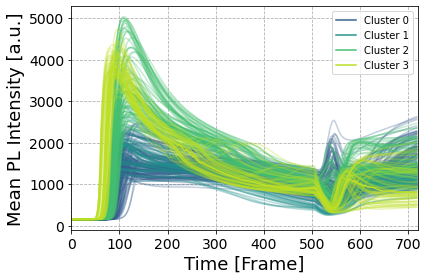

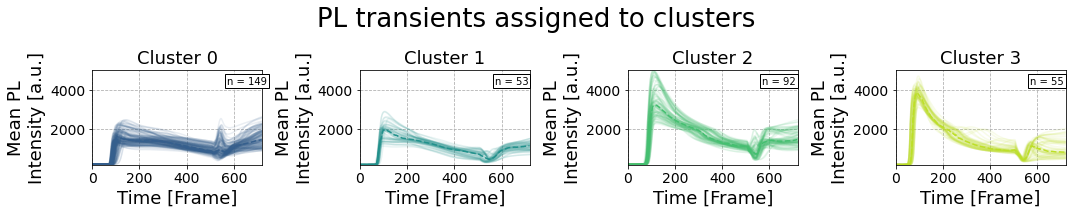

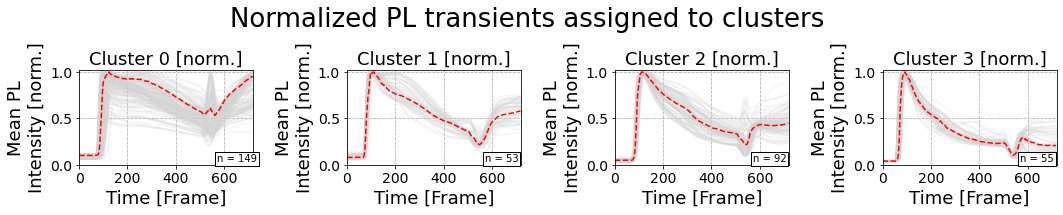

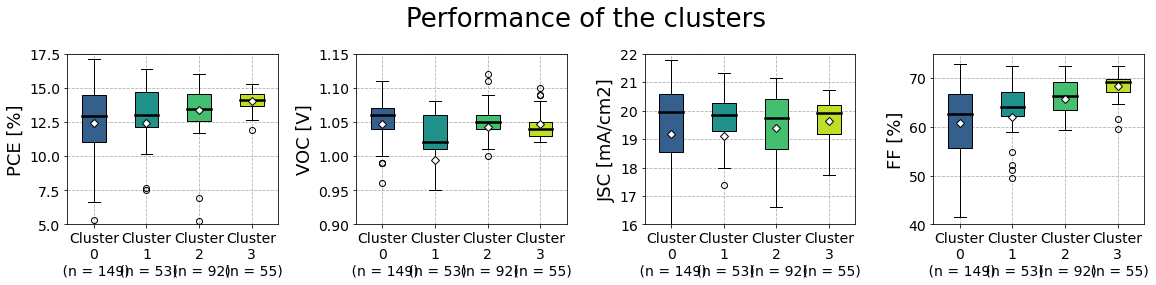

In [8]:
# plot all PL transient color-coded depending on the cluster they are assigned to
fig,ax = plt.subplots(1,1, figsize = (6,4))
for cluster, color in zip(cluster_values, color_list):
    clusterDF = testClustering.xs(cluster, level = 1)
    for row in range(len(clusterDF)):
        ax.plot(clusterDF.iloc[row], alpha = 0.3, color = color)
    ax.plot(clusterDF.median(), alpha = 0.99, color = color, label = f'Cluster {cluster}') 
ax.legend(fontsize = 10)
ax.set_xlabel("Time [Frame]", fontsize = fontSizeSetLarge)
ax.set_ylabel("Mean PL Intensity [a.u.]", fontsize = fontSizeSetLarge)
ax.grid(which = "both", linestyle = '--')
ax.tick_params(axis = 'both', which = 'major', labelsize = fontSizeSetMedium)
plt.xlim(0,720)
fig.tight_layout() 
plt.show()

# plot all PL transients assigned to the different clusters into different subplots
fig,ax = plt.subplots(1,k, figsize = (15,3))
for cluster, color in zip(cluster_values, color_list):
    clusterDF = testClustering.xs(cluster, level = 1)
    for row in range(len(clusterDF)):
        ax[cluster].plot(clusterDF.iloc[row], color = color,alpha = 0.1)
    ax[cluster].set_ylim(np.min(np.asarray(testClustering)),np.max(np.asarray(testClustering)))
    ax[cluster].text(570,4300,"n = "+str(len(clusterDF)), fontsize = 10, bbox = dict(facecolor = 'white', edgecolor = 'black', pad = 2.0))
    ax[cluster].set_title(f'Cluster {cluster}', fontsize = fontSizeSetLarge)
    ax[cluster].set_xlabel("Time [Frame]", fontsize = fontSizeSetLarge)
    ax[cluster].set_ylabel("Mean PL\nIntensity [a.u.]", fontsize = fontSizeSetLarge)
    ax[cluster].plot(clusterDF.median(), alpha = 0.99, color = color, ls = '--')
    ax[cluster].grid(which = "both", linestyle = '--')
    ax[cluster].tick_params(axis = 'both', which = 'major', labelsize = fontSizeSetMedium)
    ax[cluster].set_xlim(0,720)
plt.suptitle("PL transients assigned to clusters", fontsize = fontSizeSetTitle)
fig.tight_layout()
plt.show()

# plot all normalized PL transients assigned to the different clusters into different subplots
fig,ax = plt.subplots(1,k, figsize = (15,3))
for cluster, color in zip(cluster_values, color_list):
    clusterDF = testClustering.xs(cluster, level = 1)
    noOfcurves = 0
    for row in range(len(clusterDF)):
        currPlot = clusterDF.iloc[row]
        currPlot = np.divide(currPlot,np.max(currPlot))
        ax[cluster].plot(currPlot, "lightgray",alpha = 0.2)
        noOfcurves += 1
    ax[cluster].plot(np.divide(clusterDF.median(),np.max(clusterDF.median())), alpha = 0.99, color = "r", ls = '--', label = f'Cluster {cluster}' )
    ax[cluster].text(570,0.03,"n = "+str(noOfcurves), fontsize = 10, bbox = dict(facecolor = 'white', edgecolor = 'black', pad = 2.0))
    ax[cluster].set_title(f'Cluster {cluster} [norm.]', fontsize = fontSizeSetLarge)
    ax[cluster].set_xlabel("Time [Frame]", fontsize = fontSizeSetLarge)
    ax[cluster].set_ylabel("Mean PL\nIntensity [norm.]", fontsize = fontSizeSetLarge)
    ax[cluster].grid(which = "both", linestyle = '--')
    ax[cluster].tick_params(axis = 'both', which = 'major', labelsize = fontSizeSetMedium)
    ax[cluster].set_xlim(0,720)
    ax[cluster].set_ylim(0,1.02)
plt.suptitle("Normalized PL transients assigned to clusters", fontsize = fontSizeSetTitle)
fig.tight_layout()
plt.show()
 
# plot the performance parameters of the different clusters in the form of box plots
xlabels = []
for x in range(len(clusters)):
    xlabels.append("Cluster\n" + str(clusters[x])) 
fig,ax = plt.subplots(1,4, figsize = (16,4))
for ix, paramName in enumerate(["pce","voc","jsc","ff"]):
    bplot1 = ax[ix].boxplot(pvParamsClusters_Test[ix], medianprops = medianprops, meanprops = meanprops, meanline = False, showmeans = True,patch_artist = True) 
    cnt = 0
    for box in bplot1['boxes']:
        box.set(facecolor = color_list[cnt] ) 
        cnt += 1
    ax[ix].set_xticks(np.add(clusters,1), minor = False)
    nList = []
    for cluster, color in zip(clusters, color_list):
        nList.append("\n (n = " +str(len(pvParamsClusters_Test[3][cluster]))+")")
    newList = []
    for yy in range(len(xlabels)):
        newList.append(xlabels[yy]+nList[yy])
    ax[ix].set_xticklabels(newList, fontdict = None, minor = False, fontsize = fontSizeSetLarge)
    ax[ix].grid(which = "both", linestyle = '--')
    ax[ix].tick_params(axis = 'both', which = 'major', labelsize = fontSizeSetMedium)
ax[0].set_ylim(pceLims)
ax[1].set_ylim(vocLims)
ax[2].set_ylim(jscLims)
ax[3].set_ylim(ffLims)
ax[0].set_ylabel("PCE [%]", fontsize = fontSizeSetLarge) 
ax[1].set_ylabel("VOC [V]", fontsize = fontSizeSetLarge) 
ax[2].set_ylabel("JSC [mA/cm2]", fontsize = fontSizeSetLarge) 
ax[3].set_ylabel("FF [%]", fontsize = fontSizeSetLarge) 
plt.suptitle("Performance of the clusters", fontsize = fontSizeSetTitle)
fig.tight_layout()
plt.show()

# Compare clusters of training dataset with test data

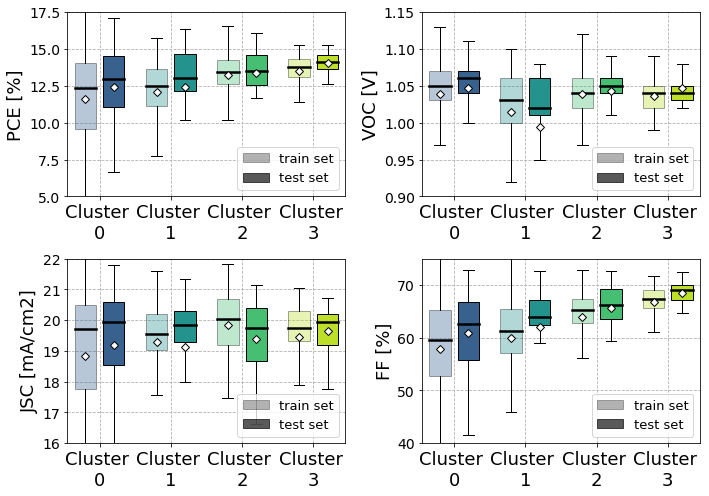

In [9]:
fig,ax = plt.subplots(2,2, figsize = (10,7))
labelNames = ['Cluster \n0', 'Cluster \n1', 'Cluster \n2', 'Cluster \n3']
pvparams = ["PCE [%] backward","VOC [V] backward","JSC [mA/cm2] backward","FF backward"]
for i in range(2):
    for j in range(2):
        boxPlot2DataSeries(ax = ax[j,i],data1 = pvParamsClusters[2*j+i],data2 = pvParamsClusters_Test[2*j+i],label1 = "train set",label2 = "test set",labelNames = labelNames,
                       xlabel = "",ylabel = pvparams[2*j+i],saveName = "",title = "",plotDots = False, save = False)
ax[0,0].set_ylim(pceLims)
ax[0,1].set_ylim(vocLims)
ax[1,0].set_ylim(jscLims)
ax[1,1].set_ylim(ffLims)
ax[0,0].set_ylabel("PCE [%]", fontsize = fontSizeSetLarge) 
ax[0,1].set_ylabel("VOC [V]", fontsize = fontSizeSetLarge) 
ax[1,0].set_ylabel("JSC [mA/cm2]", fontsize = fontSizeSetLarge) 
ax[1,1].set_ylabel("FF [%]", fontsize = fontSizeSetLarge) 
for i in range(2):
    for j in range(2):
        ax[i,j].grid(which = "both", linestyle = '--')
        ax[i,j].tick_params(axis = 'both', which = 'major', labelsize = fontSizeSetMedium)
        ax[i,j].set_xticklabels(labelNames, fontdict = None, minor = False, fontsize = fontSizeSetLarge)
        ax[i,j].legend(fontsize = 13)
fig.tight_layout() 
plt.show()